# For Issue 1279
---
Identify addresses or small areas that could benefit from more signage, increased community assistance, or other actions

# Imports and Formatting
-----

In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

# LA 311 Raw Data Imports
-----
[API Source](https://data.lacity.org/City-Infrastructure-Service-Requests/MyLA311-Service-Request-Data-2022/i5ke-k6by) | [Documentation](https://dev.socrata.com/foundry/data.lacity.org/i5ke-k6by)

In [2]:
# preserving code for just in case; API pull for most recent 1000 311 requests
'''
url = "https://data.lacity.org/resource/i5ke-k6by.json"
req = requests.get(url)
print(f'Status: {req.status_code}')

json_311 = req.json()
df_311_1000 = json_normalize(json_311)
'''

'\nurl = "https://data.lacity.org/resource/i5ke-k6by.json"\nreq = requests.get(url)\nprint(f\'Status: {req.status_code}\')\n\njson_311 = req.json()\ndf_311_1000 = json_normalize(json_311)\n'

In [3]:
# CMD LINE: python get_311_request_data_csv.py "2021-09-23" "2022-09-23"
df_311_raw = pd.read_csv('./data/21Sept23_22Sept23_api.csv')
df_311 = df_311_raw.copy()

In [4]:
df_311.head()

,Unnamed: 0,requestId,srnumber,councilId,councilName,typeId,typeName,agencyId,agencyName,sourceId,sourceName,createdDate,closedDate,address,latitude,longitude
0,0,10638529,1-2500995771,66,Panorama City,6,Illegal Dumping,3,Sanitation Bureau,8,Phone Call,2022-09-19T11:07:12,NaN,"8209 N KESTER AVE, 91402",34.219906,-118.457635
1,1,10638532,1-2500995851,11,Chatsworth,4,Bulky Items,3,Sanitation Bureau,8,Phone Call,2022-09-19T11:07:22,2022-09-20T09:35:20,"11225 N SIERRA PASS PL, 91311",34.274721,-118.610043
2,2,10638534,1-2500998901,39,Historic Highland Park,7,Metal/Appliances,3,Sanitation Bureau,17,Website,2022-09-19T11:07:35,2022-09-20T10:11:11,"243 S AVENUE 50, 90042",34.102958,-118.200271
3,3,10638536,1-2500997561,59,Northridge South,4,Bulky Items,3,Sanitation Bureau,17,Website,2022-09-19T11:07:42,2022-09-21T07:34:01,"17162 W PARTHENIA ST, 91325",34.228377,-118.508081
4,4,10638537,1-2500999011,93,Westside,7,Metal/Appliances,3,Sanitation Bureau,8,Phone Call,2022-09-19T11:07:53,2022-09-21T12:05:30,"1833 S MANNING AVE, 90025",34.051436,-118.430501


# Cleaning
---

## Arrange Columns

In [5]:
# API pull for most recent 1000 311 requests
'''
df_311_1000 = df_311_1000[['servicedate', 'requesttype', 'latitude', 'longitude',  
                'address', 'zipcode', 'nc', 'ncname', 'requestsource', 'assignto', 'owner',
                'cd', 'cdmember', 'apc', 'status']]
'''

"\ndf_311_1000 = df_311_1000[['servicedate', 'requesttype', 'latitude', 'longitude',  \n                'address', 'zipcode', 'nc', 'ncname', 'requestsource', 'assignto', 'owner',\n                'cd', 'cdmember', 'apc', 'status']]\n"

In [6]:
print(df_311.shape)
# df_311.head()

(20000, 16)


In [7]:
df_311.columns

Index(['Unnamed: 0', 'requestId', 'srnumber', 'councilId', 'councilName',
       'typeId', 'typeName', 'agencyId', 'agencyName', 'sourceId',
       'sourceName', 'createdDate', 'closedDate', 'address', 'latitude',
       'longitude'],
      dtype='object')

In [8]:
df_311 = df_311[['requestId', 'createdDate', 'closedDate', 'typeId', 'typeName', 'address', 'latitude',
       'longitude', 'agencyId', 'agencyName', 'sourceId', 'srnumber', 'sourceName', 'councilId', 'councilName']]

## Check/Handle Nulls

In [9]:
(df_311.isnull().sum().sum())/len(df_311)

0.36585

In [10]:
df_311.dropna(inplace = True)

## Check/Handle Data Types

In [11]:
df_311.dtypes

requestId        int64
createdDate     object
closedDate      object
typeId           int64
typeName        object
address         object
latitude       float64
longitude      float64
agencyId         int64
agencyName      object
sourceId         int64
srnumber        object
sourceName      object
councilId        int64
councilName     object
dtype: object

In [12]:
# Dates to datetime
df_311['createdDate'] = pd.to_datetime(df_311['createdDate'])
df_311['closedDate'] = pd.to_datetime(df_311['closedDate'])

# zip lat/lon
df_311['lat_lon'] = [(lat, lon) for lat, lon in zip(df_311['latitude'], df_311['longitude'])]
df_311 = df_311[['requestId', 'createdDate', 'closedDate', 'typeId', 'typeName', 'address', 'lat_lon', 'latitude',
       'longitude', 'agencyId', 'agencyName', 'sourceId', 'srnumber', 'sourceName', 'councilId', 'councilName']]

In [13]:
print(df_311.shape)
df_311.head()

(12683, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
1,10638532,2022-09-19 11:07:22,2022-09-20 09:35:20,4,Bulky Items,"11225 N SIERRA PASS PL, 91311","(34.2747211947, -118.610043043)",34.274721,-118.610043,3,Sanitation Bureau,8,1-2500995851,Phone Call,11,Chatsworth
2,10638534,2022-09-19 11:07:35,2022-09-20 10:11:11,7,Metal/Appliances,"243 S AVENUE 50, 90042","(34.1029581842, -118.200271159)",34.102958,-118.200271,3,Sanitation Bureau,17,1-2500998901,Website,39,Historic Highland Park
3,10638536,2022-09-19 11:07:42,2022-09-21 07:34:01,4,Bulky Items,"17162 W PARTHENIA ST, 91325","(34.2283765872, -118.508080576)",34.228377,-118.508081,3,Sanitation Bureau,17,1-2500997561,Website,59,Northridge South
4,10638537,2022-09-19 11:07:53,2022-09-21 12:05:30,7,Metal/Appliances,"1833 S MANNING AVE, 90025","(34.0514359143, -118.430501451)",34.051436,-118.430501,3,Sanitation Bureau,8,1-2500999011,Phone Call,93,Westside
5,10638538,2022-09-19 11:07:54,2022-09-20 10:19:24,1,Graffiti,"17308 W SATICOY ST, 91406","(34.2082575227, -118.510410902)",34.208258,-118.510411,4,Office of Community Beautification,17,1-2500997651,Website,44,Lake Balboa


# Explore
---

## Check .describe

In [14]:
df_311.describe(include = 'all')

,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
count,1.268300e+04,12683,12683,12683.000000,12683,12683,12683,12683.000000,12683.000000,12683.000000,12683,12683.000000,12683,12683,12683.000000,12683
unique,NaN,10060,12385,NaN,12,9849,9909,NaN,NaN,NaN,6,NaN,12683,7,NaN,100
top,NaN,2022-09-20 16:15:45,2022-09-21 08:25:15,NaN,Bulky Items,"1900 E 6TH ST, 90033","(34.0400547647, -118.21986824)",NaN,NaN,NaN,Sanitation Bureau,NaN,1-2500995851,Phone Call,NaN,Boyle Heights
freq,NaN,9,3,NaN,5771,27,27,NaN,NaN,NaN,8340,NaN,1,5020,NaN,519
first,NaN,2022-09-19 11:07:22,2022-09-19 11:15:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-09-23 16:41:32,2022-09-23 18:55:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.065634e+07,NaN,NaN,3.545297,NaN,NaN,NaN,34.075627,-118.353566,3.357171,NaN,11.396278,NaN,NaN,49.443271,NaN
std,1.231679e+04,NaN,NaN,2.172079,NaN,NaN,NaN,0.123428,0.109341,0.559925,NaN,4.884442,NaN,NaN,30.849547,NaN
min,1.063659e+07,NaN,NaN,1.000000,NaN,NaN,NaN,33.706284,-118.662958,1.000000,NaN,2.000000,NaN,NaN,0.000000,NaN
25%,1.064526e+07,NaN,NaN,1.000000,NaN,NaN,NaN,34.015985,-118.434264,3.000000,NaN,8.000000,NaN,NaN,21.000000,NaN


## typeName & address

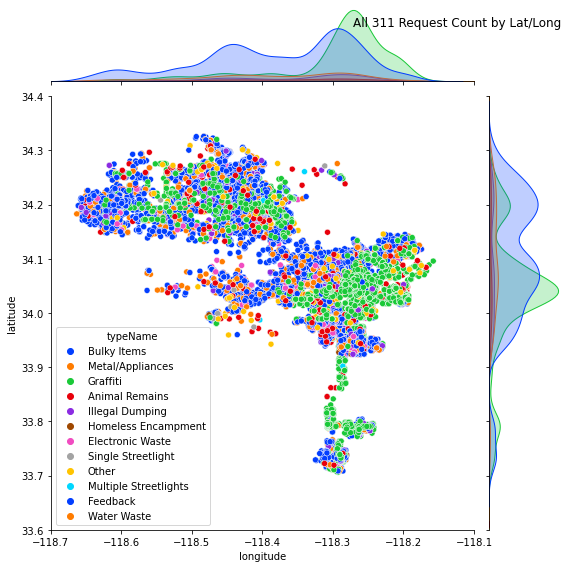

In [15]:
# All Requests
sns.jointplot(x = df_311['longitude'], y = df_311['latitude'], hue = df_311['typeName'], 
              kind='scatter', color = 'green', height = 8, palette = 'bright', 
              xlim = (-118.7, -118.1), ylim = (33.6, 34.4)
             )
plt.title('All 311 Request Count by Lat/Long', pad = 70, loc = 'right')
plt.show();

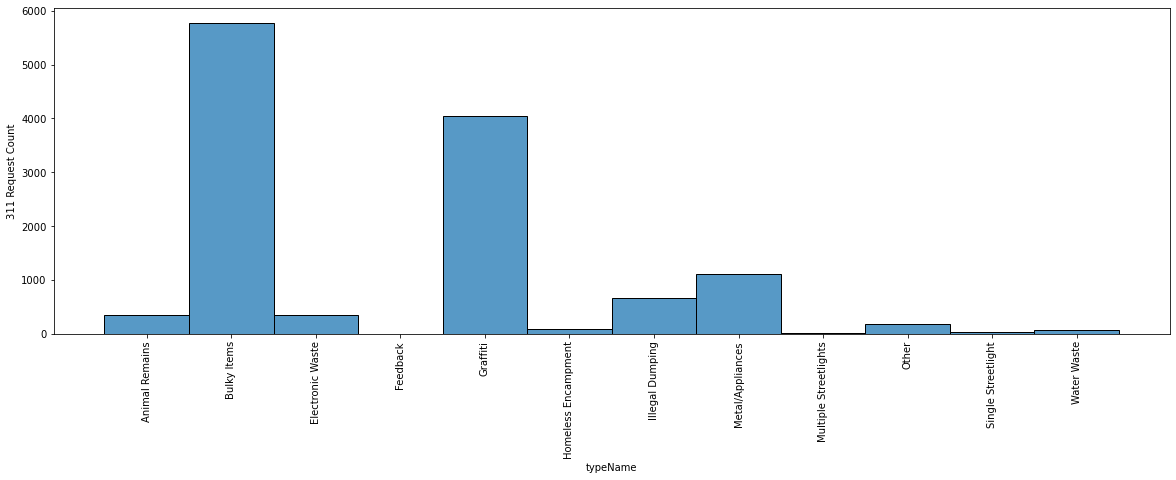

In [16]:
# Request Types
plt.figure(figsize = (20,6))
sns.histplot(df_311['typeName'].sort_values(ascending = True))
plt.xlabel('typeName')
plt.ylabel('311 Request Count')
plt.xticks(rotation=90);

## >= 2 requests for the year

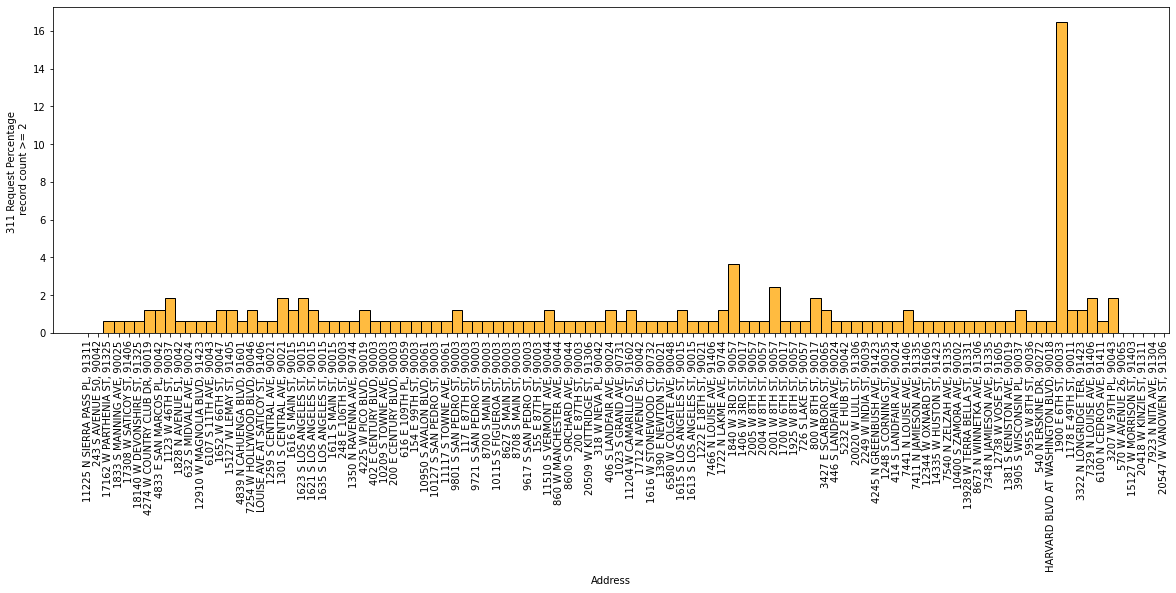

In [17]:
# Addresses - percentage of records out of addresses with more than two records
plt.figure(figsize = (20,6))
sns.histplot(df_311['address'], binrange = (2,100), color = 'orange', stat = 'percent')
plt.xlabel('Address')
plt.ylabel('311 Request Percentage \n record count >= 2')
plt.xticks(rotation=90);

In [18]:
by_address = df_311.groupby(['typeName', 'latitude', 'longitude', 'lat_lon'])['address'].value_counts().sort_values(ascending = False).reset_index(name='count')
top_by_address = by_address[by_address['count'] >= 2]

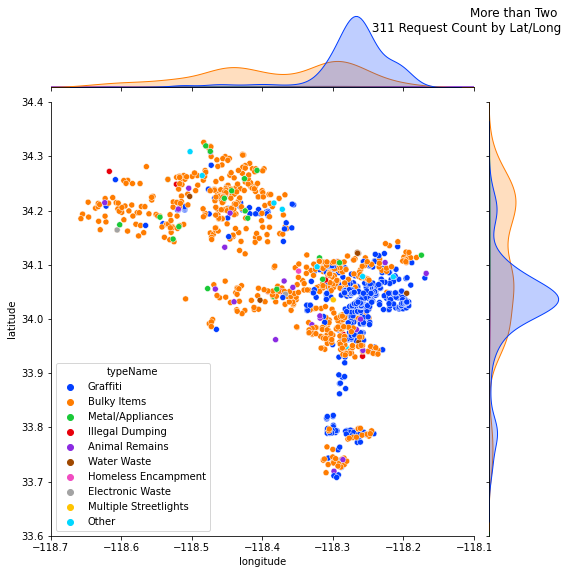

In [19]:
# Address with more than 2 requests
sns.jointplot(x = top_by_address['longitude'], y = top_by_address['latitude'], hue = top_by_address['typeName'],
              kind='scatter', color = 'green', height = 8, palette = 'bright', 
              xlim = (-118.7, -118.1), ylim = (33.6, 34.4)
             )
plt.title('More than Two \n 311 Request Count by Lat/Long', pad = 70, loc = 'right')
plt.show();

In [26]:
top_by_address.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
typeName,1313,10,Graffiti,622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,1313.0,NaN,NaN,NaN,34.061974,0.121544,33.70764,34.012461,34.050964,34.146676,34.325753
longitude,1313.0,NaN,NaN,NaN,-118.330208,0.103167,-118.657001,-118.405276,-118.29023,-118.260733,-118.167782
lat_lon,1313,1300,"(33.9840570094, -118.285494302)",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,1313,1300,"666 W 61ST ST, 90044",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,1313.0,NaN,NaN,NaN,2.318355,1.205592,2.0,2.0,2.0,2.0,27.0
